# SIR epidemic model on a Barabasi Albert network



Setup:

In [1]:
%matplotlib inline

import jack

import numpy as np
import pandas as pd

import networkx as nx
import matplotlib.pyplot as plt

import ndlib.models.epidemics as ep
import ndlib.models.ModelConfig as mc

from ndlib.viz.mpl.DiffusionTrend import DiffusionTrend
from ndlib.viz.mpl.DiffusionPrevalence import DiffusionPrevalence

Rete:

In [16]:
#%%timeit -r 1

N = 3e2 #4

G = nx.barabasi_albert_graph(N,  30, seed=1234)
nit = 500

G = jack.graph_tools(G)


## Alternativa a grah_tools(G) se si evitano i plots e si va direttamente al modello:
#
#k = G.degree()
#G.degree_list = [d for n, d in k]
#G.k_avg = np.mean(G.degree_list)

2.46 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


0

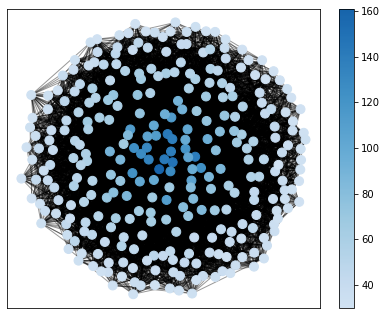

In [19]:
jack.graph_plots(G, [1])

/home/giacomo/MEGA/fst_unibo/reti complesse/complex-networks-project/jack.py:63: RuntimeWarning: divide by zero encountered in power
  return a*(x)**-b
/home/giacomo/MEGA/fst_unibo/reti complesse/complex-networks-project/jack.py:63: RuntimeWarning: divide by zero encountered in power
  return a*(x)**-b


54.0 30 [150.37602309   2.35059716]


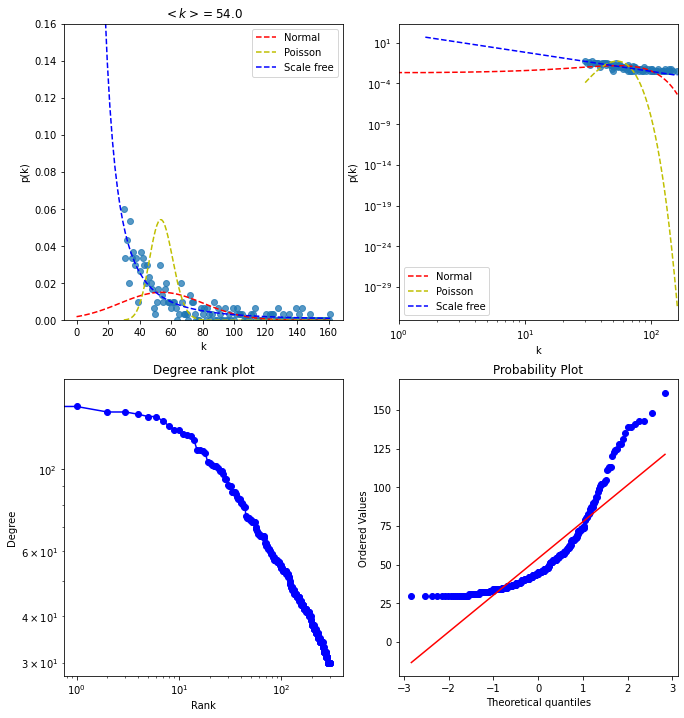

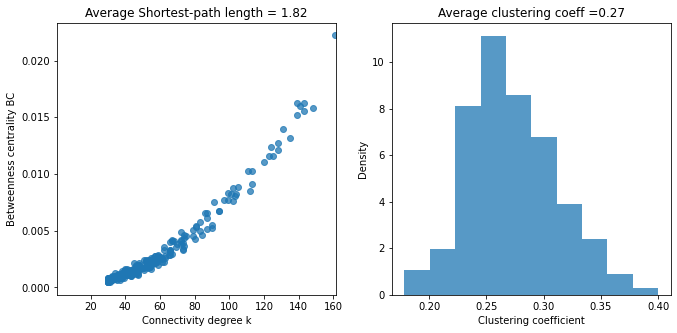

In [4]:
jack.graph_plots(G, [2,3])
print(G.k_avg, G.k_min, G.sf_pars)

Modello epidemiologico:

In [5]:
model = ep.SIRModel(G)

beta = 0.0025  # infection rate
gamma = 0.1  # recovery rate
init = 1e-2  # initial infected population

print(model.parameters)
print(model.available_statuses)

config = mc.Configuration()
config.add_model_parameter('beta',  beta)
config.add_model_parameter('gamma', gamma)
config.add_model_parameter("percentage_infected", init)

model.set_initial_status(config)

{'model': {'beta': {'descr': 'Infection rate', 'range': [0, 1], 'optional': False}, 'gamma': {'descr': 'Recovery rate', 'range': [0, 1], 'optional': False}, 'tp_rate': {'descr': 'Whether if the infection rate depends on the number of infected neighbors', 'range': [0, 1], 'optional': True, 'default': 1}}, 'nodes': {}, 'edges': {}}
{'Susceptible': 0, 'Infected': 1, 'Removed': 2}


In [6]:
iterations = model.iteration_bunch(nit, node_status=True)
trends = model.build_trends(iterations)

100%|██████████| 500/500 [00:00<00:00, 687.85it/s]


In [154]:
S = np.array([S for S, I, R in
              [list(it['node_count'].values()) for it in iterations]])
Ii = np.array([I for S, I, R in
              [list(it['node_count'].values()) for it in iterations]])

tau = int(1/gamma)
Ro = beta * tau * G.k_avg

# smoothing in funzione di tau per togliere il rumore stocastico
f = np.exp(1)     # smoothing factor (number of complete infection cycles tau)
D = int(f*tau)    # time interval of the measurements in cycles units

Is = pd.Series(list(Ii)).rolling(window=D).mean() #.iloc[D-1:].values

Rt = Ro * S/N

# stop when Ir reaches 0
idx = Ii > 0
idxs = Is > 0

# reproduction number (for each interval and smoothed)
rt  = [Ii[idx][1:]/Ii[idx][:-1], 0]
rts = [Is[idxs][1:]/Is[idxs][:-1],0]

# a posteriori
K = np.diff(np.log(Is[idxs]))/D   # growth rate
R = np.exp(K * D)                 # reproduction number from growth rate
Td = np.log(2)/K                  # doubling time

print(Ro)
print(pd.DataFrame({"K"   : K,
                    "R"   : R,
                    "Td"  : Td,
                    "rts" : rts}))

print(pd.DataFrame({"S"  : S[idx],
                    "Ii" : Ii[idx], 
                    "Rt" : Rt[idx]}))

print(pd.DataFrame({"Is" : Ii[idx]}))

1.35


<ipython-input-154-bc8f7bd631e8>:28: RuntimeWarning: divide by zero encountered in true_divide
  Td = np.log(2)/K                  # doubling time


ValueError: arrays must all be same length

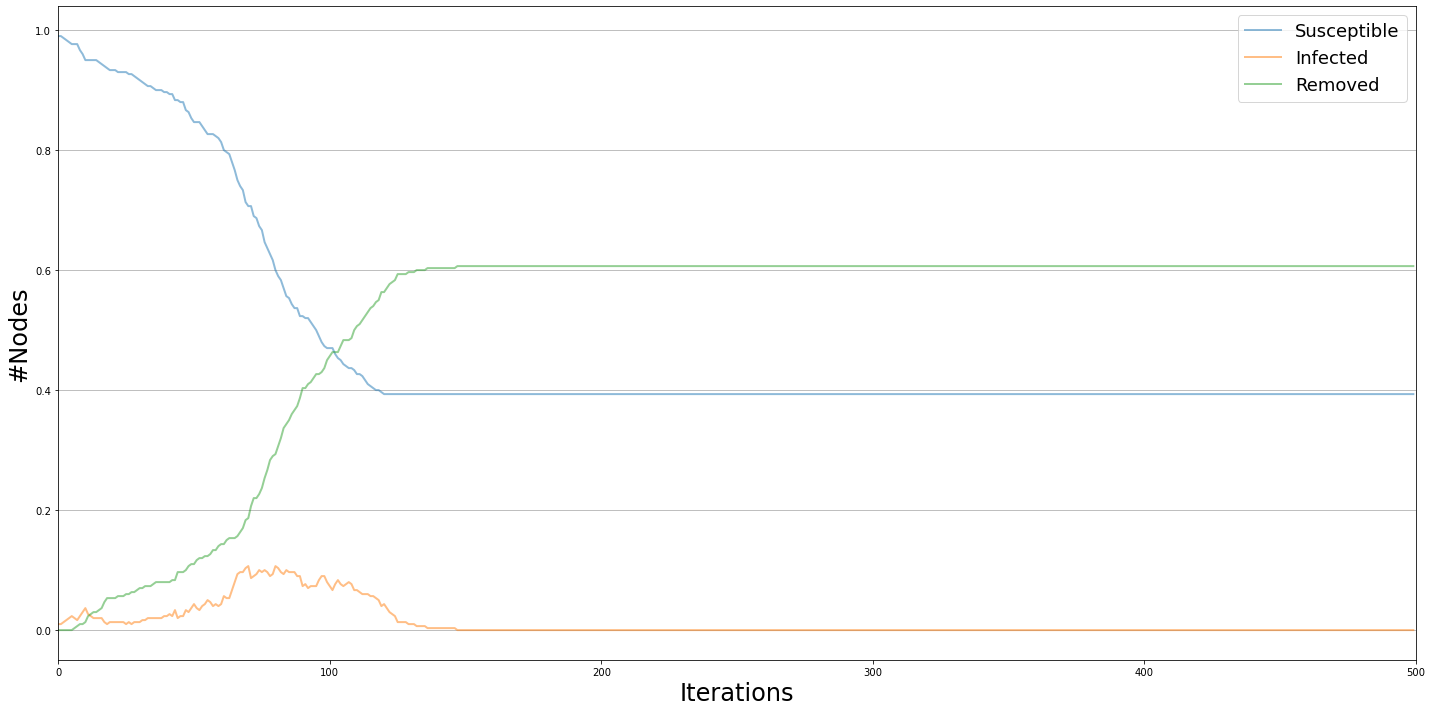

In [93]:
viz = DiffusionTrend(model, trends)
viz.plot()

#viz = DiffusionPrevalence(model, trends)
#viz.plot()

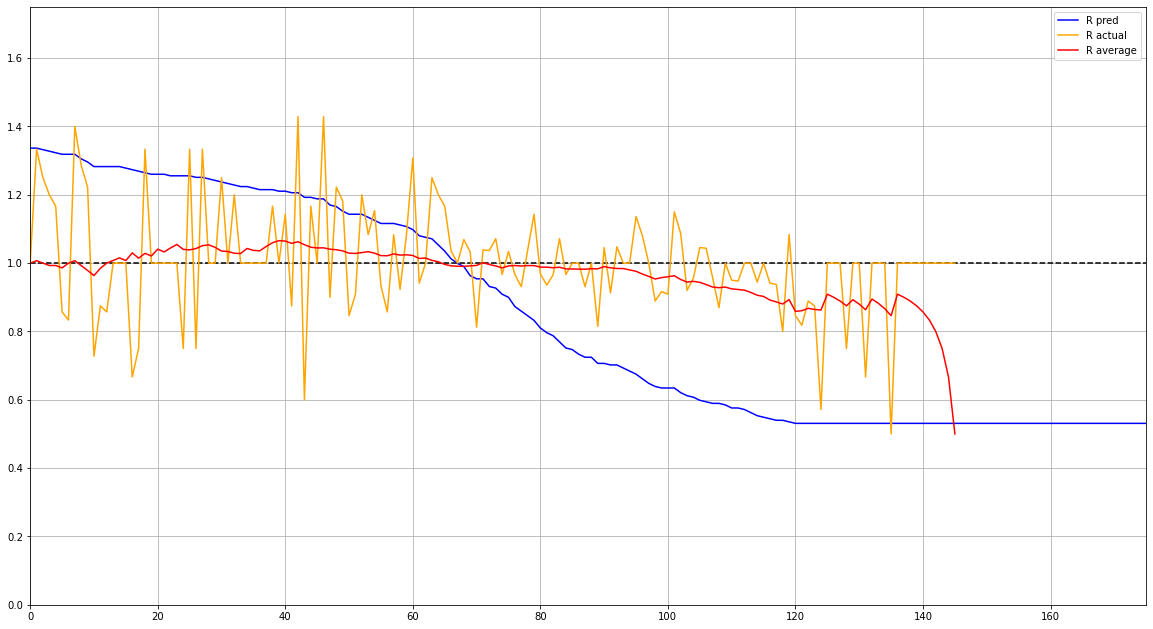

In [147]:
figR = plt.figure(figsize=(20, 11)) # 
plt.plot([1 for i in range(500)], 'k--')
plt.plot(Rt, 'blue', label='R pred')
plt.plot(rt, 'orange', label='R actual')
plt.plot(rts, 'red', label='R moving average')
plt.legend(loc='best')
plt.xlim([0,175])
plt.ylim([0,1.75])
plt.grid()

**Definisco una soglia di ospedalizzazione massima.**


All'approssimarsi della soglia faccio intervenire meccanismi di mitigazione/contenimento del contagio. 

1. beta si riduce (mascherine)
2. la connettività media si abbassa (lockdown)

come intervengo sui k? 
* provo a tagliare la coda ad alti k
* riduco in modo random (una percentuale a tutte le scale)

Salvare entrambi gli scenari (pandas dataset?) e fare un confronto per valutare la bontà delle misure (strategie di attacco)

Valutare le percentuali finali di popolazione interessate dal contagio